# Project 1: MTA Trunstile Data (Exploratory Data Analysis) 
## Chicago - Winter 2020 (chi20_ds13): 
### Team #1 - Ake Paramadilok, Andrew Way, Anthony Ghabour
***

## 1. Objective

Use MTA subway (and other) data to help optimize the placement of street teams at entrances to subway stations to identify individuals passionate about technology who might attend a gala at the beginning of the summer.

Use python and pandas to perform exploratory data analysis and create visualizations via Matplotlib & Seaborn.

## 2. Workbook Setup & Data Extraction

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from datetime import datetime as dt
import matplotlib.pyplot as plt
import folium
import geopy.geocoders
from geopy.geocoders import Nominatim
geopy.geocoders.options.default_user_agent = 'Metis MTA Project 1'
geopy.geocoders.options.default_timeout = 15
geolocator = Nominatim()

%matplotlib inline

####     MTA Data Source: http://web.mta.info/developers/turnstile.html

From http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt:

    Field Description

    C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS

    C/A      = Control Area (A002)
    UNIT     = Remote Unit for a station (R051)
    SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)
    STATION  = Represents the station name the device is located at
    LINENAME = Represents all train lines that can be boarded at this station
               Normally lines are represented by one character.  LINENAME 456NQR repersents train server 
               for 4, 5, 6, N, Q, and R trains.
    DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND   
    DATE     = Represents the date (MM-DD-YY)
    TIME     = Represents the time (hh:mm:ss) for a scheduled audit event
    DESc     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)
               1. Audits may occur more that 4 hours due to planning, or troubleshooting activities. 
               2. Additionally, there may be a "RECOVR AUD" entry: This refers to missed audit that was recovered. 
    ENTRIES  = The comulative entry register value for a device
    EXIST    = The cumulative exit register value for a device


Analysis will focus on MTA activity occuring in late Spring (four weeks ending May 25, 2019) in advance of gala event in early Summer.

In [2]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

week_nums = [190504, 190511, 190518, 190525]
MTA_df = get_data(week_nums).reset_index(drop=True)

## 3. Data Wrangling & Cleanup
Let's perform some initial high-level checks. What elements are provided? 

In [3]:
MTA_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [4]:
MTA_df.columns = [column.strip() for column in MTA_df.columns]
MTA_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

Confirm data reflects the period of interest.

In [5]:
MTA_df.DATE.value_counts().sort_index()

04/27/2019    28914
04/28/2019    28982
04/29/2019    30972
04/30/2019    28982
05/01/2019    29624
05/02/2019    29871
05/03/2019    29512
05/04/2019    28963
05/05/2019    28954
05/06/2019    29008
05/07/2019    30355
05/08/2019    29280
05/09/2019    28793
05/10/2019    28735
05/11/2019    28807
05/12/2019    28922
05/13/2019    29877
05/14/2019    30074
05/15/2019    30589
05/16/2019    29940
05/17/2019    30472
05/18/2019    29052
05/19/2019    29225
05/20/2019    29501
05/21/2019    30146
05/22/2019    27745
05/23/2019    28021
05/24/2019    29673
Name: DATE, dtype: int64

What are the applicable data types? Is there any missing information?

In [6]:
MTA_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822989 entries, 0 to 822988
Data columns (total 11 columns):
C/A         822989 non-null object
UNIT        822989 non-null object
SCP         822989 non-null object
STATION     822989 non-null object
LINENAME    822989 non-null object
DIVISION    822989 non-null object
DATE        822989 non-null object
TIME        822989 non-null object
DESC        822989 non-null object
ENTRIES     822989 non-null int64
EXITS       822989 non-null int64
dtypes: int64(2), object(9)
memory usage: 69.1+ MB


Note that date and time are provided as text. Let's combine and convert that information into a single column as a datetime object. Additionally, our analysis will not need to consider time to the nearest minute, so we'll drop minutes and seconds, only keeping time information in terms of hours.

In [7]:
MTA_df["DATE_TIME"] = pd.to_datetime(MTA_df.DATE + " " + MTA_df.TIME, format="%m/%d/%Y %H:%M:%S")
MTA_df["DATE_TIME"] = MTA_df["DATE_TIME"].transform(lambda x: x.replace(minute = 0, second = 0))

Confirm transformation above worked as intended.

In [8]:
MTA_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822989 entries, 0 to 822988
Data columns (total 12 columns):
C/A          822989 non-null object
UNIT         822989 non-null object
SCP          822989 non-null object
STATION      822989 non-null object
LINENAME     822989 non-null object
DIVISION     822989 non-null object
DATE         822989 non-null object
TIME         822989 non-null object
DESC         822989 non-null object
ENTRIES      822989 non-null int64
EXITS        822989 non-null int64
DATE_TIME    822989 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 75.3+ MB


Next, visually inspect and review a few sample records - first, last, and/or random entries.

In [9]:
display(MTA_df.head())
display(MTA_df.tail())
display(MTA_df.sample(5))

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,00:00:00,REGULAR,7035249,2384833,2019-04-27 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,7035269,2384840,2019-04-27 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,7035292,2384875,2019-04-27 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,7035392,2384951,2019-04-27 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,7035651,2385020,2019-04-27 16:00:00


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
822984,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/24/2019,05:00:00,REGULAR,5554,378,2019-05-24 05:00:00
822985,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/24/2019,09:00:00,REGULAR,5554,378,2019-05-24 09:00:00
822986,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/24/2019,13:00:00,REGULAR,5554,378,2019-05-24 13:00:00
822987,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/24/2019,17:00:00,REGULAR,5554,378,2019-05-24 17:00:00
822988,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/24/2019,21:00:00,REGULAR,5554,378,2019-05-24 21:00:00


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
430523,B031,R172,01-06-00,BRIGHTON BEACH,BQ,BMT,05/12/2019,04:00:00,REGULAR,1687814,6621905,2019-05-12 04:00:00
783626,R259,R307,00-00-00,138/GRAND CONC,45,IRT,05/22/2019,12:00:00,REGULAR,3777876,3508933,2019-05-22 12:00:00
192226,R533,R055,00-00-07,FLUSHING-MAIN,7,IRT,04/27/2019,12:00:00,REGULAR,2891123,1122962,2019-04-27 12:00:00
349250,R168A,R168,00-03-02,96 ST,123,IRT,05/04/2019,09:00:00,REGULAR,11491639,11481553,2019-05-04 09:00:00
804481,R525,R018,02-06-01,74 ST-BROADWAY,7EFMR,IRT,05/20/2019,16:00:00,REGULAR,54049,3595557,2019-05-20 16:00:00


Turnstiles are uniquely identified by a combination of four elements. Let's create a unique identifier to facilitate manipulating later on.<br/> Similarly, sometimes distinct stations (i.e. on different lines) have the same name. 

In [10]:
MTA_df["TURNSTILE"] = (
    MTA_df['C/A'] + ' ' +
    MTA_df['UNIT'] + ' ' +
    MTA_df['SCP'] + ' ' +
    MTA_df['STATION'])

MTA_df["STATION"] = (
    MTA_df['STATION'] + ' ' +
    MTA_df['LINENAME'] )

In [11]:
MTA_df.DESC.value_counts()

REGULAR       819398
RECOVR AUD      3591
Name: DESC, dtype: int64

"Recover audits" are scarce relative to "Regular" audits (less than 0.5% of all records) and may be more likely to involve irregular information, so let's ignore them. 

In [12]:
MTA_df = MTA_df[MTA_df.DESC == "REGULAR"]

Drop columns we no longer need (much of the information has been incorporated into other columns by now). 

In [13]:
MTA_df = MTA_df.drop(["C/A", "UNIT", "SCP", "DESC", "DIVISION", "LINENAME"], axis=1, errors="ignore")

Sanity Check to verify that "TURNSTILE", "DATE_TIME" combinations are unique.

In [14]:
MTA_df = MTA_df.sort_values("DATE_TIME")
(MTA_df 
 .sort_values("DATE_TIME")
 .groupby(["TURNSTILE", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head()

,TURNSTILE,DATE_TIME,ENTRIES
600249,R210 R044 00-05-01 BROOKLYN BRIDGE,2019-05-14 18:00:00,45
598890,R210 R044 00-00-01 BROOKLYN BRIDGE,2019-05-14 18:00:00,45
599907,R210 R044 00-03-05 BROOKLYN BRIDGE,2019-05-14 18:00:00,45
598720,R210 R044 00-00-00 BROOKLYN BRIDGE,2019-05-14 18:00:00,45
599060,R210 R044 00-03-00 BROOKLYN BRIDGE,2019-05-14 18:00:00,45


Let's take a closer look.

In [15]:
mask = ((MTA_df["TURNSTILE"] == "R210 R044 00-03-00 BROOKLYN BRIDGE") & 
        (MTA_df["DATE_TIME"].dt.date == datetime.datetime(2019, 5, 14).date()))

MTA_df[mask].head(10)

,STATION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,TURNSTILE
565152,BROOKLYN BRIDGE 456JZ,05/14/2019,00:00:00,1572455,2648298,2019-05-14 00:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE
565153,BROOKLYN BRIDGE 456JZ,05/14/2019,04:00:00,1572470,2648313,2019-05-14 04:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE
565154,BROOKLYN BRIDGE 456JZ,05/14/2019,08:00:00,1572506,2648643,2019-05-14 08:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE
565155,BROOKLYN BRIDGE 456JZ,05/14/2019,12:00:00,1572686,2649727,2019-05-14 12:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE
565156,BROOKLYN BRIDGE 456JZ,05/14/2019,16:00:00,1573181,2650380,2019-05-14 16:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE
565157,BROOKLYN BRIDGE 456JZ,05/14/2019,17:51:02,1573539,2650741,2019-05-14 17:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE
565163,BROOKLYN BRIDGE 456JZ,05/14/2019,17:59:04,1573560,2650776,2019-05-14 17:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE
565162,BROOKLYN BRIDGE 456JZ,05/14/2019,17:57:42,1573557,2650768,2019-05-14 17:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE
565161,BROOKLYN BRIDGE 456JZ,05/14/2019,17:56:22,1573553,2650761,2019-05-14 17:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE
565160,BROOKLYN BRIDGE 456JZ,05/14/2019,17:55:02,1573547,2650761,2019-05-14 17:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE


Note that there are multiple entries for the same "hour" with small increases in entries and exits. This is easily cleaned up as follows.

In [16]:
MTA_df.drop_duplicates(subset = ["TURNSTILE", "DATE_TIME"], keep="last", inplace = True)

In [17]:
mask = ((MTA_df["TURNSTILE"] == "R210 R044 00-03-00 BROOKLYN BRIDGE") & 
        (MTA_df["DATE_TIME"].dt.date == datetime.datetime(2019, 5, 14).date()))

MTA_df[mask].head(10)

,STATION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,TURNSTILE
565152,BROOKLYN BRIDGE 456JZ,05/14/2019,00:00:00,1572455,2648298,2019-05-14 00:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE
565153,BROOKLYN BRIDGE 456JZ,05/14/2019,04:00:00,1572470,2648313,2019-05-14 04:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE
565154,BROOKLYN BRIDGE 456JZ,05/14/2019,08:00:00,1572506,2648643,2019-05-14 08:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE
565155,BROOKLYN BRIDGE 456JZ,05/14/2019,12:00:00,1572686,2649727,2019-05-14 12:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE
565156,BROOKLYN BRIDGE 456JZ,05/14/2019,16:00:00,1573181,2650380,2019-05-14 16:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE
565158,BROOKLYN BRIDGE 456JZ,05/14/2019,17:52:22,1573543,2650746,2019-05-14 17:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE
565208,BROOKLYN BRIDGE 456JZ,05/14/2019,18:59:03,1573705,2650924,2019-05-14 18:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE
565215,BROOKLYN BRIDGE 456JZ,05/14/2019,19:08:19,1573729,2650941,2019-05-14 19:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE
565229,BROOKLYN BRIDGE 456JZ,05/14/2019,20:00:00,1573796,2650998,2019-05-14 20:00:00,R210 R044 00-03-00 BROOKLYN BRIDGE


Confirm ALL duplicates properly removed.

In [18]:
(MTA_df 
 .sort_values("DATE_TIME")
 .groupby(["TURNSTILE", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,TURNSTILE,DATE_TIME,ENTRIES
0,A002 R051 02-00-00 59 ST,2019-04-27 00:00:00,1
539762,R143 R032 02-00-00 TIMES SQ-42 ST,2019-05-04 12:00:00,1
539764,R143 R032 02-00-00 TIMES SQ-42 ST,2019-05-04 20:00:00,1
539765,R143 R032 02-00-00 TIMES SQ-42 ST,2019-05-05 00:00:00,1
539766,R143 R032 02-00-00 TIMES SQ-42 ST,2019-05-05 04:00:00,1


Since time data provided not especially granular, let's separate each day into morning and evening commutes. 

In [19]:
MTA_df.loc[MTA_df.DATE_TIME.dt.time < datetime.time(13), 'COMMUTE'] = "Morning"
MTA_df.loc[MTA_df.DATE_TIME.dt.time >= datetime.time(13), 'COMMUTE'] = "Evening"

Let's see what we have.

In [20]:
display(MTA_df.head())

,STATION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,TURNSTILE,COMMUTE
0,59 ST NQR456W,04/27/2019,00:00:00,7035249,2384833,2019-04-27,A002 R051 02-00-00 59 ST,Morning
135000,14 ST 123FLM,04/27/2019,00:00:00,5909864,3052255,2019-04-27,R128 R105 01-00-02 14 ST,Morning
135042,14 ST 123FLM,04/27/2019,00:00:00,1344334,655618,2019-04-27,R128 R105 01-03-00 14 ST,Morning
135084,14 ST 123FLM,04/27/2019,00:00:00,6937255,3830435,2019-04-27,R128 R105 01-03-01 14 ST,Morning
135126,14 ST 123FLM,04/27/2019,00:00:00,1359599,697204,2019-04-27,R128 R105 01-03-02 14 ST,Morning


Since entry and exit information is cumulative, need to shift and take differences in order to get net counts for each day, turnstile, commute.

In [21]:
MTA_df[["PREV_DATE_TIME", "PREV_ENTRIES", "PREV_EXITS"]] = (
    MTA_df.groupby(["TURNSTILE"])["DATE_TIME", "ENTRIES", "EXITS"]
          .transform(lambda grp: grp.shift(1)))
MTA_df.describe()

,ENTRIES,EXITS,PREV_ENTRIES,PREV_EXITS
count,8.096550e+05,8.096550e+05,8.047850e+05,8.047850e+05
mean,4.127798e+07,3.379135e+07,4.127204e+07,3.378827e+07
std,2.106998e+08,1.942629e+08,2.106779e+08,1.942546e+08
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.542140e+05,1.452410e+05,3.543210e+05,1.452750e+05
50%,2.176850e+06,1.247628e+06,2.177031e+06,1.247790e+06
75%,6.790646e+06,4.599952e+06,6.790856e+06,4.600349e+06
max,2.129343e+09,2.124127e+09,2.129343e+09,2.124127e+09


In [22]:
MTA_df.describe()

,ENTRIES,EXITS,PREV_ENTRIES,PREV_EXITS
count,8.096550e+05,8.096550e+05,8.047850e+05,8.047850e+05
mean,4.127798e+07,3.379135e+07,4.127204e+07,3.378827e+07
std,2.106998e+08,1.942629e+08,2.106779e+08,1.942546e+08
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.542140e+05,1.452410e+05,3.543210e+05,1.452750e+05
50%,2.176850e+06,1.247628e+06,2.177031e+06,1.247790e+06
75%,6.790646e+06,4.599952e+06,6.790856e+06,4.600349e+06
max,2.129343e+09,2.124127e+09,2.129343e+09,2.124127e+09


Street teams won't care if people are coming or going, so we'll combine entries and exits to determine "total targets" at each station and limit to a reasonable amount per time period (10,000).

In [23]:
def get_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we are not giving a counter that's too big
        return 0
    return counter

MTA_df["TOTAL_TARGETS"] = MTA_df.apply(get_counts, axis=1, max_counter=1000000)
MTA_df = MTA_df[(MTA_df.TOTAL_TARGETS <= 10000)]

3 5176463.0
8 2021820.0
607125572 594469.0
29 6333363.0
107 6546797.0
326 3756473.0
1129054485 2501642.0
115 12739117.0
39 3912187.0
68858058 436510383.0
458752 100663296.0
65536 839317244.0
12 4887309.0
12 13653626.0
131075 2222584.0
50 1544151.0
335090794 3422305.0
184608117 746400.0
182 2357557.0
70 2898346.0
39 4605762.0
134 3073070.0
119 7480484.0
16778671 81157.0
637573806 2503363.0
2223006 131075.0
230239 1887921.0
1888605 230239.0
683737068 458752.0
254 1068632.0
84 10463114.0
196625 68461853.0
1058563 102390700.0
187 9441238.0
72 8876720.0
10 7602234.0
140396510 1577638984.0
146 36966629.0
2063648840 8123329.0
1150 4768484.0
905996203 3558247.0
30933207 6069289.0
196614 2998692.0
191 15418871.0
423 6527930.0
1178879075 4472670.0
158 6999851.0
4666 2204424.0
569319973 4807409.0
67 1087620.0
170 9030142.0


In [24]:
MTA_df.describe()

,ENTRIES,EXITS,PREV_ENTRIES,PREV_EXITS,TOTAL_TARGETS
count,8.046330e+05,8.046330e+05,8.046330e+05,8.046330e+05,804633.000000
mean,4.127754e+07,3.379048e+07,4.127152e+07,3.378781e+07,180.165198
std,2.106900e+08,1.942581e+08,2.106737e+08,1.942531e+08,265.773502
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,3.546350e+05,1.453420e+05,3.546100e+05,1.453090e+05,11.000000
50%,2.177631e+06,1.248010e+06,2.177713e+06,1.248069e+06,77.000000
75%,6.792008e+06,4.601036e+06,6.791966e+06,4.601168e+06,247.000000
max,2.129343e+09,2.124127e+09,2.129343e+09,2.124127e+09,9988.000000


Create final, clean data set for exploratory analysis.  Export as csv to handoff to teammate for additional analysis and plotting.

In [25]:
MTA_EDA_df = MTA_df[["STATION", "DATE", "COMMUTE", "TOTAL_TARGETS"]]
MTA_EDA_df.to_csv(r'MTA_EDA.csv', index = None, header=True)

## 4. Exploratory Analysis
### Importing Data and Adding Appropriate Columns

In [26]:
# Import csv into a dataframe object and preview contents

filename = 'MTA_EDA.csv'
mta_data = pd.read_csv(filename)
mta_data.head()

,STATION,DATE,COMMUTE,TOTAL_TARGETS
0,14 ST-UNION SQ LNQR456W,04/27/2019,Morning,19.0
1,14 ST-UNION SQ LNQR456W,04/27/2019,Morning,15.0
2,14 ST-UNION SQ LNQR456W,04/27/2019,Morning,3.0
3,14 ST-UNION SQ LNQR456W,04/27/2019,Morning,39.0
4,14 ST-UNION SQ LNQR456W,04/27/2019,Morning,75.0


In [27]:
# Check data characteristics
mta_data.describe()

,TOTAL_TARGETS
count,804633.000000
mean,180.165198
std,265.773502
min,0.000000
25%,11.000000
50%,77.000000
75%,247.000000
max,9988.000000


In [28]:
# Convert DATE column to datetime obj
mta_data['DATE'] = pd.to_datetime(mta_data['DATE'])

# Create WEEKDAY column with string describing day of week
mta_data['WEEKDAY'] = mta_data['DATE'].dt.day_name()
mta_data.head()

,STATION,DATE,COMMUTE,TOTAL_TARGETS,WEEKDAY
0,14 ST-UNION SQ LNQR456W,2019-04-27,Morning,19.0,Saturday
1,14 ST-UNION SQ LNQR456W,2019-04-27,Morning,15.0,Saturday
2,14 ST-UNION SQ LNQR456W,2019-04-27,Morning,3.0,Saturday
3,14 ST-UNION SQ LNQR456W,2019-04-27,Morning,39.0,Saturday
4,14 ST-UNION SQ LNQR456W,2019-04-27,Morning,75.0,Saturday


In [29]:
# Create column with Day Type i.e. weekend or weekday
# mta_data now has all columns we need for analysis

weekend_days = ['Saturday','Sunday']
mta_data['DAY_TYPE'] = mta_data['WEEKDAY'].apply(lambda x: 'weekend' if x in weekend_days else 'weekday') 
mta_data.head()

,STATION,DATE,COMMUTE,TOTAL_TARGETS,WEEKDAY,DAY_TYPE
0,14 ST-UNION SQ LNQR456W,2019-04-27,Morning,19.0,Saturday,weekend
1,14 ST-UNION SQ LNQR456W,2019-04-27,Morning,15.0,Saturday,weekend
2,14 ST-UNION SQ LNQR456W,2019-04-27,Morning,3.0,Saturday,weekend
3,14 ST-UNION SQ LNQR456W,2019-04-27,Morning,39.0,Saturday,weekend
4,14 ST-UNION SQ LNQR456W,2019-04-27,Morning,75.0,Saturday,weekend


In [30]:
# Group dataframe by STATION, DATE, COMMUTE, DAY_TYPE and deep copy to mta_grp

mta_grp = (mta_data.groupby(['STATION','DATE','COMMUTE','DAY_TYPE'])
                  .sum()
                  .reset_index()
                  .sort_values("TOTAL_TARGETS", ascending=False)
                  .copy())
mta_grp

,STATION,DATE,COMMUTE,DAY_TYPE,TOTAL_TARGETS
17386,GRD CNTRL-42 ST 4567S,2019-05-13,Evening,weekday,122107.0
17388,GRD CNTRL-42 ST 4567S,2019-05-14,Evening,weekday,120815.0
17362,GRD CNTRL-42 ST 4567S,2019-05-01,Evening,weekday,114695.0
17406,GRD CNTRL-42 ST 4567S,2019-05-23,Evening,weekday,114044.0
17402,GRD CNTRL-42 ST 4567S,2019-05-21,Evening,weekday,113739.0
...,...,...,...,...,...
3775,215 ST 1,2019-05-18,Evening,weekend,0.0
4181,231 ST 1,2019-04-27,Evening,weekend,0.0
22825,PENNSYLVANIA AV 3,2019-05-19,Evening,weekend,0.0
9531,AQUEDUCT N.COND A,2019-04-28,Evening,weekend,0.0


### Organize Dataframes for Weekend vs Weekday Rideship Scatter Plots

In [31]:
# Create new grouping of dataframe that will be passed into pivot function for use in scatter plot generation

to_pivot = (mta_grp.groupby(['STATION','DAY_TYPE'])
                  .mean()
                  .reset_index()
                  .sort_values("TOTAL_TARGETS", ascending=False))
to_pivot.head(15)

,STATION,DAY_TYPE,TOTAL_TARGETS
622,GRD CNTRL-42 ST 4567S,weekday,79477.800
178,34 ST-HERALD SQ BDFMNQRW,weekday,63448.075
204,42 ST-PORT AUTH ACENQRS1237W,weekday,46527.500
186,34 ST-PENN STA ACE,weekday,42977.325
54,14 ST-UNION SQ LNQR456W,weekday,36618.975
179,34 ST-HERALD SQ BDFMNQRW,weekend,34820.000
893,TIMES SQ-42 ST 1237ACENQRSW,weekday,34540.800
602,FULTON ST 2345ACJZ,weekday,32545.275
212,47-50 STS ROCK BDFM,weekday,31848.850
246,59 ST COLUMBUS ABCD1,weekday,30521.950


In [32]:
# Pivot Day_Type data into their own columns containing new columns of Weekday and Weekend housing 
# respective Total_Target values in preparatoin for scatter plot creation

scatter_data = to_pivot.pivot('STATION','DAY_TYPE','TOTAL_TARGETS')

In [33]:
# Sort dataframe for descending weekday volume and save first 10 rows to create a scatter for only top 10 stations.
scatter_data_Top10 =(scatter_data.sort_values("weekday", ascending=False)
                                .round()
                                .head(10))

scatter_data_Top10

DAY_TYPE,weekday,weekend
STATION,,
GRD CNTRL-42 ST 4567S,79478.0,26703.0
34 ST-HERALD SQ BDFMNQRW,63448.0,34820.0
42 ST-PORT AUTH ACENQRS1237W,46528.0,26248.0
34 ST-PENN STA ACE,42977.0,22033.0
14 ST-UNION SQ LNQR456W,36619.0,20515.0
TIMES SQ-42 ST 1237ACENQRSW,34541.0,21328.0
FULTON ST 2345ACJZ,32545.0,10859.0
47-50 STS ROCK BDFM,31849.0,10415.0
59 ST COLUMBUS ABCD1,30522.0,18579.0


In [34]:
# Sort dataframe for descending weekend volume figures just to see it
(scatter_data.sort_values("weekend", ascending=False)
            .round()
            .head(10))

DAY_TYPE,weekday,weekend
STATION,,
34 ST-HERALD SQ BDFMNQRW,63448.0,34820.0
GRD CNTRL-42 ST 4567S,79478.0,26703.0
42 ST-PORT AUTH ACENQRS1237W,46528.0,26248.0
34 ST-PENN STA ACE,42977.0,22033.0
TIMES SQ-42 ST 1237ACENQRSW,34541.0,21328.0
14 ST-UNION SQ LNQR456W,36619.0,20515.0
59 ST COLUMBUS ABCD1,30522.0,18579.0
JKSN HT-ROOSVLT EFMR7,25519.0,17077.0
CANAL ST JNQRZ6W,24026.0,17062.0


## 5. Plotting and Visualization

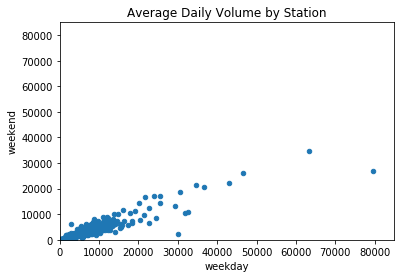

In [35]:
# Create scatter plot of average daily station traffic on weekends vs. weekdays at ALL stations

%matplotlib inline
weekend_day_scat = scatter_data.plot.scatter('weekday','weekend');

plt.xlim([0,85000]);
plt.ylim([0,85000]); 
#make y-axis scale even with x-axis scalling to emphasize tilt in data towards commuters (weekday rider)
plt.title('Average Daily Volume by Station')

figure = weekend_day_scat.get_figure()    
figure.savefig('Weekday vs Weekend Traffic', dpi=400, bbox_inches='tight',pad_inches=.25,)

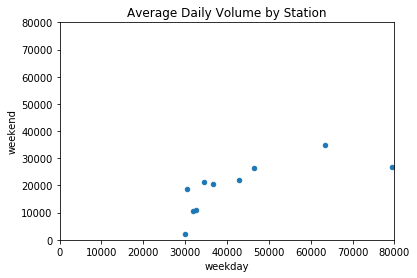

In [36]:
# Create scatter plot of top 10 stations with highest weekday traffic vs their weekend traffic
# Chart not useful and was not added to presentation

%matplotlib inline
weekend_day_scat = scatter_data_Top10.plot.scatter('weekday','weekend');
plt.xlim([0,80000]);
plt.ylim([0,80000]);
plt.title('Average Daily Volume by Station')
figure = weekend_day_scat.get_figure()    
figure.savefig('Weekday vs Weekend Traffic_top10', dpi=400, bbox_inches='tight',pad_inches=.25,)

### Organize Dataframe for Horizontal Bar Charts

In [37]:
# Group Dataframe by Station and Commute in prep for pivot and save as deep copy after reseting indicies.

mta_grp2 = (mta_grp.groupby(['STATION','COMMUTE'])
                   .mean()
                   .sort_values("TOTAL_TARGETS", ascending=False)
                   .reset_index() 
                   .copy())
mta_grp2

,STATION,COMMUTE,TOTAL_TARGETS
0,GRD CNTRL-42 ST 4567S,Evening,88990.107143
1,34 ST-HERALD SQ BDFMNQRW,Evening,66530.250000
2,14 ST-UNION SQ LNQR456W,Evening,51303.821429
3,42 ST-PORT AUTH ACENQRS1237W,Morning,47118.928571
4,34 ST-HERALD SQ BDFMNQRW,Morning,44007.000000
...,...,...,...
949,BROAD CHANNEL AS,Evening,96.357143
950,BEACH 105 ST AS,Morning,96.321429
951,BEACH 105 ST AS,Evening,86.750000
952,ORCHARD BEACH 6,Evening,2.000000


In [38]:
# Create dataframe for PM Ridership Bar Chart for Top 10 stations and pivot data to columns for use in plt

mta_grp2_pivot=mta_grp2.pivot('STATION','COMMUTE','TOTAL_TARGETS').reset_index()
mta_evening_10 = mta_grp2_pivot.sort_values("Evening", ascending=False)\
    .rename(columns={'Evening':'Average PM Ridership','Morning':'Average AM Ridership'})
mta_evening_10.round()

COMMUTE,STATION,Average PM Ridership,Average AM Ridership
311,GRD CNTRL-42 ST 4567S,88990.0,39809.0
89,34 ST-HERALD SQ BDFMNQRW,66530.0,44007.0
27,14 ST-UNION SQ LNQR456W,51304.0,12732.0
301,FULTON ST 2345ACJZ,41804.0,10895.0
106,47-50 STS ROCK BDFM,39230.0,12220.0
...,...,...,...
199,BEACH 44 ST A,194.0,408.0
203,BEACH 98 ST AS,182.0,198.0
220,BROAD CHANNEL AS,96.0,175.0
196,BEACH 105 ST AS,87.0,96.0


In [39]:
# Sort dataframe for AM Ridership Bar Chart for Top 10 stations

mta_morning_10 = (mta_grp2_pivot.sort_values("Morning", ascending=False)
                               .reset_index()
                               .rename(columns={'Evening':'Average PM Ridership',\
                                                'Morning':'Average AM Ridership'}))
mta_morning_10.round()

COMMUTE,index,STATION,Average PM Ridership,Average AM Ridership
0,102,42 ST-PORT AUTH ACENQRS1237W,34348.0,47119.0
1,89,34 ST-HERALD SQ BDFMNQRW,66530.0,44007.0
2,311,GRD CNTRL-42 ST 4567S,88990.0,39809.0
3,93,34 ST-PENN STA ACE,34741.0,39245.0
4,288,FLUSHING-MAIN 7,19627.0,29614.0
...,...,...,...,...
472,273,E 143/ST MARY'S 6,668.0,224.0
473,203,BEACH 98 ST AS,182.0,198.0
474,220,BROAD CHANNEL AS,96.0,175.0
475,196,BEACH 105 ST AS,87.0,96.0


In [40]:
# TOP 20 Stations - volume per day

mta_grp3 = (mta_grp2.groupby(['STATION'])
            .sum()
            .reset_index()
            .sort_values("TOTAL_TARGETS", ascending=False)
            .rename(columns={'TOTAL_TARGETS':'Average Daily Ridership'}))
mta_top_10 = mta_grp3.head(10)
mta_top_10.to_csv(r'MTA_Top10.csv', index = None, header=True)
mta_top_10

,STATION,Average Daily Ridership
311,GRD CNTRL-42 ST 4567S,128798.785714
89,34 ST-HERALD SQ BDFMNQRW,110537.250000
102,42 ST-PORT AUTH ACENQRS1237W,81466.928571
93,34 ST-PENN STA ACE,73986.428571
27,14 ST-UNION SQ LNQR456W,64035.464286
447,TIMES SQ-42 ST 1237ACENQRSW,61531.392857
123,59 ST COLUMBUS ABCD1,54219.428571
301,FULTON ST 2345ACJZ,52698.464286
106,47-50 STS ROCK BDFM,51449.928571
288,FLUSHING-MAIN 7,49241.464286


### Create Function to Create Bar Charts

In [41]:
# Horizontal bar chart of Top Stations

def top_stations(dataframe, num_stations_to_include, col_x_data, col_y_data, title, save_image_name):
    
    dataframe = dataframe.head(num_stations_to_include)
    top_station_all = (sns.barplot(x = col_x_data, 
                                   y = col_y_data, 
                                   data = dataframe, 
                                   orient="h")
                                   .set_title(title));
    
    # store figure to name
    figure = top_station_all.get_figure()    
    
    # save figure and export, bbox_inches "tight" to define margins, which were initially cutting off station names
    figure.savefig(save_image_name, dpi=400, bbox_inches='tight',pad_inches=.25)

In [42]:
# Reset index and rename column in order to control bar chart axis name ('Average Daily Ridership')

(mta_grp3.reset_index()
         .round()
         .rename(columns={'TOTAL_TARGETS':'Average Daily Ridership'})
         .head(10));

### Create Bar Charts For AM and PM Ridership Using top_stations( ) Function

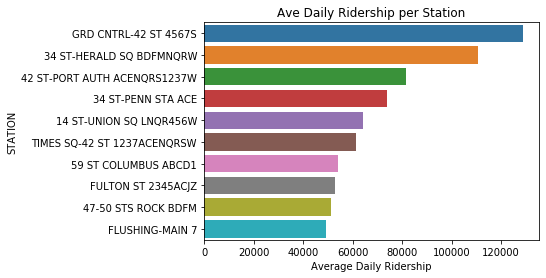

In [43]:
top_stations(dataframe = mta_grp3, 
             num_stations_to_include = 10,
             col_x_data = 'Average Daily Ridership', 
             col_y_data = 'STATION',
             title = 'Ave Daily Ridership per Station', 
             save_image_name = 'Ave_Daily_Vol');

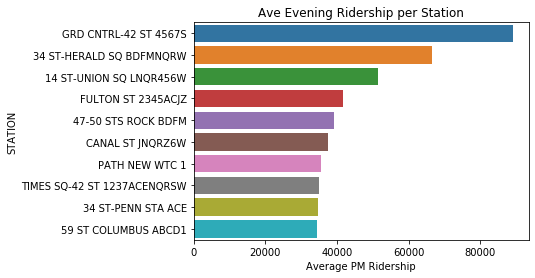

In [44]:
# Create PM Ridership Bar Chart
top_stations(dataframe = mta_evening_10, 
             num_stations_to_include = 10,
             col_x_data = 'Average PM Ridership', 
             col_y_data = 'STATION',
             title = 'Ave Evening Ridership per Station', 
             save_image_name = 'Top_PM_Vol');

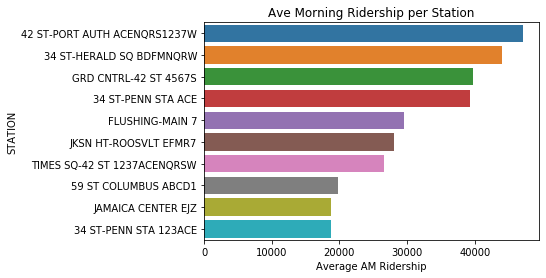

In [45]:
# Create AM Ridership Bar Chart
top_stations(dataframe = mta_morning_10, 
             num_stations_to_include = 10,
             col_x_data = 'Average AM Ridership', 
             col_y_data = 'STATION',
             title = 'Ave Morning Ridership per Station', 
             save_image_name = 'Top_AM_Vol');

## 6. Maps

In [46]:
offices_sqft = pd.read_csv('Location Data - Largest SQFT.csv')
offices_pop = pd.read_csv('Location Data - Most Employees.csv')
station_data = pd.read_csv('NYC_Transit_Subway_Entrance_And_Exit_Data.csv')

In [47]:
def add_coords(dataframe):
    '''
    Accepts dataframe of location data with address column,
    Adds 2 new float columns to dataframe with latitude and longitude coordinates
    for later use in folium map
    
    Relies on geopy geocode information
    Geopy returns 2 cols:
        0: str containing descriptive data related to address
        1: tuple containing latitude and longitude as floats
    
    '''
    lat,lon = [],[]
    for i in range(len(dataframe)):
        location = geolocator.geocode(dataframe['Location'][i])
        lat.append(location[-1][0])
        lon.append(location[-1][1])

    dataframe['Latitude'] = lat
    dataframe['Longitude'] = lon

In [48]:
add_coords(offices_sqft)
add_coords(offices_pop)
#No need to add coordinates to the MTA data, it's already in there

In [49]:
station_data.rename(columns=lambda x: x.strip().replace(' ','_'), inplace=True)

In [50]:
station_data.columns

Index(['Division', 'Line', 'Station_Name', 'Station_Latitude',
       'Station_Longitude', 'Route1', 'Route2', 'Route3', 'Route4', 'Route5',
       'Route6', 'Route7', 'Route8', 'Route9', 'Route10', 'Route11',
       'Entrance_Type', 'Entry', 'Exit_Only', 'Vending', 'Staffing',
       'Staff_Hours', 'ADA', 'ADA_Notes', 'Free_Crossover',
       'North_South_Street', 'East_West_Street', 'Corner', 'Entrance_Latitude',
       'Entrance_Longitude', 'Station_Location', 'Entrance_Location'],
      dtype='object')

In [51]:
for i in range(1,12):
    station_data[f'Route{i}']=station_data[f'Route{i}'].astype(str)
    station_data[f'Route{i}']=station_data[f'Route{i}'].str.replace('nan','')

    
    '''
    Some MTA lines have numbers for names
    and they're in this df as either floats or ints.
    This code converts them to strings to concatenate into
    an identifying code to prevent overlaps in station names
    '''


In [52]:
station_data['Station_ID'] =\
station_data['Division']+' '+\
station_data['Line']+' '+\
station_data['Station_Name']+' '+\
station_data['Route1']+\
station_data['Route2']+\
station_data['Route3']+\
station_data['Route4']+\
station_data['Route5']+\
station_data['Route6']+\
station_data['Route7']+\
station_data['Route8']+\
station_data['Route9']+\
station_data['Route10']+\
station_data['Route11']

#concatenating individual info into identifying column

In [53]:
station_legend = station_data[['Station_Name','Station_ID','Station_Latitude','Station_Longitude']]
station_legend.drop_duplicates(inplace=True)
station_legend.reset_index(drop=True,inplace=True)

#This block creates a legend with just the columns I want,
#then removes the repeat entries and resets the index

/Users/andrewway/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [54]:
mta_top_10.reset_index(drop=True,inplace=True)

In [55]:
mta_top_10

,STATION,Average Daily Ridership
0,GRD CNTRL-42 ST 4567S,128798.785714
1,34 ST-HERALD SQ BDFMNQRW,110537.250000
2,42 ST-PORT AUTH ACENQRS1237W,81466.928571
3,34 ST-PENN STA ACE,73986.428571
4,14 ST-UNION SQ LNQR456W,64035.464286
5,TIMES SQ-42 ST 1237ACENQRSW,61531.392857
6,59 ST COLUMBUS ABCD1,54219.428571
7,FULTON ST 2345ACJZ,52698.464286
8,47-50 STS ROCK BDFM,51449.928571
9,FLUSHING-MAIN 7,49241.464286


This next section is pretty ugly and manual.  Given that these datasets have markedly different conventions for name formatting, I'll be poking around to find the correct coordinates and then attach them to the appropriate entry, based on my own domain knowledge of the MTA.  I chose this tactic because the connection between the turnstile 'STATION' entry and station legend 'Station_Name' entry was rather ambiguous. I also knew this  would only be for 10 items, and with the understanding that it isn't scalable much further beyond this quantity.



_A Way_

In [56]:
mta_top_10.iloc[0]

STATION                    GRD CNTRL-42 ST 4567S
Average Daily Ridership                   128799
Name: 0, dtype: object

In [57]:
def legend_finder(search_query):
    return station_legend[station_legend['Station_Name'].str.contains(search_query)]

    '''
    This function is a shortcut to search for a string in a station name
    Input: string, one you expect to be in the station name
    Output: df containing entries where input is present in station name
    '''

In [58]:
legend_finder('Grand Central')

,Station_Name,Station_ID,Station_Latitude,Station_Longitude
295,Grand Central,IRT 42nd St Shuttle Grand Central GS4567,40.752769,-73.979189
365,Grand Central-42nd St,IRT Flushing Grand Central-42nd St GS4567,40.751431,-73.976041
423,Grand Central-42nd St,IRT Lexington Grand Central-42nd St GS4567,40.751776,-73.976848


8 of our 10 top stations are junctions, stations that serve 2 or more unique lines.  This means that our station legend (and the datasets preceding it) have seperate entries and coordinates for each section of platforms.  For example, in the case of Grand Central, there are 3 entries:

Station Name | Description
:--|:--
IRT Lexington Grand Central-42nd St | the 4/5/6 trains running North/South
IRT Flushing Grand Central-42nd St GS4567 | the 7 train running East/West
IRT 42nd St Shuttle Grand Central | the S shuttle, a half-length train connecting Grand Central to Times Square

Given that our geographical coordinates extend to 6 decimal places, and that differences in geographical coordinates at the 4th decimal place are a maximum of ~30 feet at the equator, these differences are negligible.

I'll be using my best judgement to focus on the platform that is closest to ground level and closest to the center of the station, based on renderings from http://www.projectsubwaynyc.com/.

_A Way_

In [59]:
lat_list = []
lon_list = [] #we will add coordinates in order to these two lists, then add them to our top 10

In [60]:
def coord_add(station_string):
    lat_list.append(station_legend[station_legend.Station_ID == station_string]
                              ['Station_Latitude'])
    lon_list.append(station_legend[station_legend.Station_ID == station_string]
                              ['Station_Longitude'])
    return 'coords_added'

In [61]:
coord_add('IRT Lexington Grand Central-42nd St GS4567') #4/5/6 platform

'coords_added'

In [62]:
mta_top_10.iloc[1]

STATION                    34 ST-HERALD SQ BDFMNQRW
Average Daily Ridership                      110537
Name: 1, dtype: object

In [63]:
legend_finder('34th')

,Station_Name,Station_ID,Station_Latitude,Station_Longitude
42,34th St,BMT Broadway 34th St BDFMNQR,40.749567,-73.987950
149,34th St,IND 6 Avenue 34th St BDFMNQR,40.749719,-73.987823
180,34th St,IND 8 Avenue 34th St ACE,40.752287,-73.993391
314,34th St,IRT Broadway-7th Ave 34th St 123,40.750373,-73.991057


In [64]:
coord_add('BMT Broadway 34th St BDFMNQR') #N/Q/R/W platform

'coords_added'

In [65]:
mta_top_10.iloc[2]

STATION                    42 ST-PORT AUTH ACENQRS1237W
Average Daily Ridership                         81466.9
Name: 2, dtype: object

In [66]:
legend_finder('42nd')

,Station_Name,Station_ID,Station_Latitude,Station_Longitude
55,Times Square-42nd St,BMT Broadway Times Square-42nd St ACENQRS1.02....,40.754672,-73.986754
150,42nd St,IND 6 Avenue 42nd St BDFM7,40.754222,-73.984569
181,42nd St,IND 8 Avenue 42nd St ACENQRS1.02.03.07.0,40.757308,-73.989735
333,Van Cortlandt Park-242nd St,IRT Broadway-7th Ave Van Cortlandt Park-242nd ...,40.889248,-73.898583
365,Grand Central-42nd St,IRT Flushing Grand Central-42nd St GS4567,40.751431,-73.976041
423,Grand Central-42nd St,IRT Lexington Grand Central-42nd St GS4567,40.751776,-73.976848


In [67]:
coord_add('IND 8 Avenue 42nd St ACENQRS1.02.03.07.0') #'PORT-AUTH' implies 8th avenue line

'coords_added'

In [68]:
mta_top_10.iloc[3]

STATION                    34 ST-PENN STA ACE
Average Daily Ridership               73986.4
Name: 3, dtype: object

In [69]:
legend_finder('34th')

,Station_Name,Station_ID,Station_Latitude,Station_Longitude
42,34th St,BMT Broadway 34th St BDFMNQR,40.749567,-73.987950
149,34th St,IND 6 Avenue 34th St BDFMNQR,40.749719,-73.987823
180,34th St,IND 8 Avenue 34th St ACE,40.752287,-73.993391
314,34th St,IRT Broadway-7th Ave 34th St 123,40.750373,-73.991057


In [70]:
coord_add('IND 8 Avenue 34th St ACE') #Not a junction, no comparisons needed

'coords_added'

In [71]:
mta_top_10.iloc[4]

STATION                    14 ST-UNION SQ LNQR456W
Average Daily Ridership                    64035.5
Name: 4, dtype: object

In [72]:
legend_finder('Union')

,Station_Name,Station_ID,Station_Latitude,Station_Longitude
14,Union St,BMT 4 Avenue Union St R,40.677316,-73.983110
56,Union Square,BMT Broadway Union Square LNQR456,40.735736,-73.990568
102,Union Square,BMT Canarsie Union Square LNQR456,40.734789,-73.990730
273,Kew Gardens-Union Turnpike,IND Queens Boulevard Kew Gardens-Union Turnpik...,40.714441,-73.831008
399,14th St-Union Square,IRT Lexington 14th St-Union Square LNQR456,40.734673,-73.989951


In [73]:
coord_add('BMT Canarsie Union Square LNQR456') #L train straddles B'way and Lexington lines

'coords_added'

In [74]:
mta_top_10.iloc[5]

STATION                    TIMES SQ-42 ST 1237ACENQRSW
Average Daily Ridership                        61531.4
Name: 5, dtype: object

In [75]:
legend_finder('Times')

,Station_Name,Station_ID,Station_Latitude,Station_Longitude
55,Times Square-42nd St,BMT Broadway Times Square-42nd St ACENQRS1.02....,40.754672,-73.986754
296,Times Square,IRT 42nd St Shuttle Times Square ACENQRGS1.02....,40.755983,-73.986229
332,Times Square,IRT Broadway-7th Ave Times Square ACENQRS1.02....,40.755290,-73.987495


In [76]:
coord_add('BMT Broadway Times Square-42nd St ACENQRS1.02.03.07.0')
# These lines are so close that this one doesn't really matter

'coords_added'

In [77]:
mta_top_10.iloc[6]

STATION                    59 ST COLUMBUS ABCD1
Average Daily Ridership                 54219.4
Name: 6, dtype: object

In [78]:
legend_finder('59th')

,Station_Name,Station_ID,Station_Latitude,Station_Longitude
4,59th St,BMT 4 Avenue 59th St NR,40.641362,-74.017881
183,59th St,IND 8 Avenue 59th St ABCD1,40.768296,-73.981736
316,59th St-Columbus Circle,IRT Broadway-7th Ave 59th St-Columbus Circle A...,40.768247,-73.981929
404,59th St,IRT Lexington 59th St NQR456,40.762526,-73.967967


In [79]:
coord_add('IND 8 Avenue 59th St ABCD1') # 4 of 5 lines at this station are at the aforementioned platform

'coords_added'

In [80]:
mta_top_10.iloc[7]

STATION                    FULTON ST 2345ACJZ
Average Daily Ridership               52698.5
Name: 7, dtype: object

In [81]:
legend_finder('Fulton')

,Station_Name,Station_ID,Station_Latitude,Station_Longitude
121,Fulton St,BMT Nassau Fulton St ACJZ2345.0,40.710374,-74.007582
218,Fulton St,IND Crosstown Fulton St G,40.687119,-73.975375
336,Fulton St,IRT Clark Fulton St ACJZ2345.0,40.709416,-74.006571
422,Fulton St,IRT Lexington Fulton St ACJZ2345.0,40.710368,-74.009509


In [82]:
coord_add('BMT Nassau Fulton St ACJZ2345.0') #J/Z Nassau line is most central at this location

'coords_added'

In [83]:
mta_top_10.iloc[8]

STATION                    47-50 STS ROCK BDFM
Average Daily Ridership                51449.9
Name: 8, dtype: object

In [84]:
legend_finder('47-50')

,Station_Name,Station_ID,Station_Latitude,Station_Longitude
151,47-50th Sts Rockefeller Center,IND 6 Avenue 47-50th Sts Rockefeller Center BDFM,40.758663,-73.981329
152,47-50th Sts Rockefeller Center,IND 6 Avenue 47-50th Sts Rockefeller Center BDFM7,40.758663,-73.981329


In [85]:
coord_add('IND 6 Avenue 47-50th Sts Rockefeller Center BDFM') #another non-junction

'coords_added'

In [86]:
mta_top_10.iloc[9]

STATION                    FLUSHING-MAIN 7
Average Daily Ridership            49241.5
Name: 9, dtype: object

In [87]:
legend_finder('Flushing')

,Station_Name,Station_ID,Station_Latitude,Station_Longitude
67,Flushing Av,BMT Broadway Jamaica Flushing Av JM,40.700260,-73.941126
217,Flushing Av,IND Crosstown Flushing Av G,40.700377,-73.950234
364,Flushing-Main St,IRT Flushing Flushing-Main St 7,40.759600,-73.830030


In [88]:
coord_add('IRT Flushing Flushing-Main St 7') #non-junction

'coords_added'

In [89]:
mta_top_10['Latitude']=lat_list
mta_top_10['Longitude']=lon_list

/Users/andrewway/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/andrewway/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [90]:
mta_top_10.head()

,STATION,Average Daily Ridership,Latitude,Longitude
0,GRD CNTRL-42 ST 4567S,128798.785714,"423 40.751776 Name: Station_Latitude, dtype...","423 -73.976848 Name: Station_Longitude, dtyp..."
1,34 ST-HERALD SQ BDFMNQRW,110537.250000,"42 40.749567 Name: Station_Latitude, dtype:...","42 -73.98795 Name: Station_Longitude, dtype:..."
2,42 ST-PORT AUTH ACENQRS1237W,81466.928571,"181 40.757308 Name: Station_Latitude, dtype...","181 -73.989735 Name: Station_Longitude, dtyp..."
3,34 ST-PENN STA ACE,73986.428571,"180 40.752287 Name: Station_Latitude, dtype...","180 -73.993391 Name: Station_Longitude, dtyp..."
4,14 ST-UNION SQ LNQR456W,64035.464286,"102 40.734789 Name: Station_Latitude, dtype...","102 -73.99073 Name: Station_Longitude, dtype..."


In [91]:
nycmap = folium.Map(location=[40.73,-73.982155], 
                    width=1024, 
                    height=760, 
                    tiles="cartodbpositron", 
                    zoom_start=12)

for i in range(len(mta_top_10)):
    folium.Circle([mta_top_10['Latitude'][i], mta_top_10['Longitude'][i]],
                  popup=mta_top_10['STATION'][i],
                  radius = 300,
                  color = 'crimson',
                  fill = True
                  ).add_to(nycmap)


for i in range(len(offices_pop)):
    folium.Circle([offices_pop.iloc[i]['Latitude'], offices_pop.iloc[i]['Longitude']],
                  popup=offices_pop.iloc[i]['Company'],
                  radius= 10,
                  fill=True,
                  color = 'blue'
                  ).add_to(nycmap)

for i in range(len(offices_sqft)):
    folium.Circle([offices_sqft.iloc[i]['Latitude'], offices_sqft.iloc[i]['Longitude']],
                   popup=offices_sqft.iloc[i]['Company'],
                   radius= 10,
                   fill=True,
                   color = 'blue').add_to(nycmap)

nycmap.save('nycmap.html')
nycmap